<a href="https://colab.research.google.com/github/rafaelsudbrackzimmermann/-MachineLearning/blob/main/CytologIA_DINOBLOOM_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [80]:
from google.colab import drive
import shutil
import os

# Montar o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rafaelzimmermann1_cytologia_dataset_path = kagglehub.dataset_download('rafaelzimmermann1/cytologia-dataset')
rafaelzimmermann1_cytologia_aug_1_path = kagglehub.dataset_download('rafaelzimmermann1/cytologia-aug-1')

print('Data source import complete.')


Data source import complete.


# inicio

In [81]:
# Bibliotecas principais
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer

# Visualização e avaliação
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from PIL import Image

In [96]:
DEBUG = False
# Configuration for model training
FOLDS = 3
EPOCHS = 10
BATCH = 32
VERBOSE = 1
MODEL_NAME = 'dinov2_vits14'
MODEL_DOWNLOAD = 'DinoBloom-S.pth'
!wget "https://zenodo.org/records/10908163/files/DinoBloom-S.pth?download=1" -O dinobloom-s.pth
MODEL_PATH = 'dinobloom-s.pth'

PATH_IMAGES = f'{rafaelzimmermann1_cytologia_dataset_path}/images/dataset_cytologia/'
PATH_IMAGES_AUG = f'{rafaelzimmermann1_cytologia_aug_1_path}/aug_full_crop_0_5/'
SPEC_SIZE  = (224, 224, 3)
CLASSES = ['PNN', 'MO', 'MM', 'LyB', 'LGL', 'Thromb', 'LLC', 'LAM3', 'EO',
       'LY', 'BA', 'MoB', 'LM', 'LH_lyAct', 'Lysee', 'Er', 'LF', 'LZMG',
       'MBL', 'SS', 'PM', 'B', 'M']
N_CLASSES = len(CLASSES)
TARGETS = CLASSES

--2024-12-26 19:53:12--  https://zenodo.org/records/10908163/files/DinoBloom-S.pth?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 265416526 (253M) [application/octet-stream]
Saving to: ‘dinobloom-s.pth’

dinobloom-s.pth     100%[===================>] 253.12M  17.6MB/s    in 16s     

2024-12-26 19:53:28 (15.9 MB/s) - ‘dinobloom-s.pth’ saved [265416526/265416526]



In [97]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
# Carregar os dados
train =  pd.read_csv(f"{rafaelzimmermann1_cytologia_dataset_path}/cytologia-data-train.csv")
test_ = pd.read_csv(f"{rafaelzimmermann1_cytologia_dataset_path}/box_preditions_test_data_formated.csv")
if DEBUG:
    train = train[:1000].copy()
    test_ = test_[:1000].copy()
    EPOCHS = 1
else:
    train = train.copy()
    test_ = test_.copy()

train

,NAME,x1,y1,x2,y2,class
0,cf7734a2-b.jpg,99,88,266,276,PNN
1,e6a3b579-0.jpg,92,78,272,284,MO
2,60f95776-f.jpg,110,103,251,251,MM
3,0894e581-c.jpg,112,121,248,262,LyB
4,3998a979-3.jpg,94,86,276,281,MO
...,...,...,...,...,...,...
52743,ddd3c8e9-5.jpg,133,132,226,231,LF
52744,1fa717be-0.jpg,109,112,252,257,M
52745,1e923263-9.jpg,174,177,446,429,MoB
52746,08112a14-8.jpg,122,135,241,248,LyB


In [98]:
from sklearn.preprocessing import LabelEncoder

# Codificar as classes como números inteiros
label_encoder = LabelEncoder()
train['class_enum'] = label_encoder.fit_transform(train['class'])

# Salve o mapeamento para futuras referências
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:", class_mapping)

Class Mapping: {'B': 0, 'BA': 1, 'EO': 2, 'Er': 3, 'LAM3': 4, 'LF': 5, 'LGL': 6, 'LH_lyAct': 7, 'LLC': 8, 'LM': 9, 'LY': 10, 'LZMG': 11, 'LyB': 12, 'Lysee': 13, 'M': 14, 'MBL': 15, 'MM': 16, 'MO': 17, 'MoB': 18, 'PM': 19, 'PNN': 20, 'SS': 21, 'Thromb': 22}


In [99]:
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd

df = pd.DataFrame(train)

# Adicionar contagem ao DataFrame original
df['count'] = df.groupby('NAME')['NAME'].transform('count')

# Obter IDs únicos e suas contagens
image_ids_counts = df[['NAME', 'count']].drop_duplicates()

# Inicializar o StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

# Preparar um DataFrame para mapear cada 'NAME' ao seu 'fold'
fold_df = pd.DataFrame({'NAME': image_ids_counts['NAME'].unique()})

# Aplicar o StratifiedGroupKFold e armazenar os resultados diretamente no DataFrame 'fold_df'
fold_df['fold'] = -1  # Inicializar a coluna 'fold' com -1

display(fold_df)

for fold_number, (train_idx, val_idx) in enumerate(sgkf.split(X=image_ids_counts, y=image_ids_counts['count'], groups=image_ids_counts['NAME'])):
    fold_df.loc[val_idx, 'fold'] = fold_number

# Mapear a coluna 'fold' de volta para o DataFrame original usando merge
df = df.merge(fold_df, on='NAME', how='left')

df['fold'].value_counts()
df

,NAME,fold
0,cf7734a2-b.jpg,-1
1,e6a3b579-0.jpg,-1
2,60f95776-f.jpg,-1
3,0894e581-c.jpg,-1
4,3998a979-3.jpg,-1
...,...,...
48412,7e5a4a15-3.jpg,-1
48413,ddd3c8e9-5.jpg,-1
48414,1fa717be-0.jpg,-1
48415,1e923263-9.jpg,-1


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


,NAME,x1,y1,x2,y2,class,class_enum,count,fold
0,cf7734a2-b.jpg,99,88,266,276,PNN,20,1,0
1,e6a3b579-0.jpg,92,78,272,284,MO,17,1,2
2,60f95776-f.jpg,110,103,251,251,MM,16,1,2
3,0894e581-c.jpg,112,121,248,262,LyB,12,1,2
4,3998a979-3.jpg,94,86,276,281,MO,17,1,2
...,...,...,...,...,...,...,...,...,...
52743,ddd3c8e9-5.jpg,133,132,226,231,LF,5,1,2
52744,1fa717be-0.jpg,109,112,252,257,M,14,1,1
52745,1e923263-9.jpg,174,177,446,429,MoB,18,1,1
52746,08112a14-8.jpg,122,135,241,248,LyB,12,1,2


# dataset

In [100]:
!pip install datasets
!pip install --upgrade evaluate
!pip install accelerate -U

In [101]:
import requests
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [102]:
model = torch.hub.load('facebookresearch/dinov2', MODEL_NAME)

# Inspeciona os módulos do modelo
print(model)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [103]:
# # Itera sobre os blocos do Transformer
# for idx, block in enumerate(model.blocks):
#     print(f"Bloco {idx}:")
#     print(block)
#     print("-" * 50)


In [104]:
#########################################################
# 1) IMPORTS GERAIS
#########################################################

import os
import random
import gc
import pickle
import numpy as np
import pandas as pd

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm

#########################################################
# 2) FUNÇÕES DE UTILIDADE (SEED, FREEZE, ETC.)
#########################################################
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def freeze_model_layers(
    model,
    freeze_patch_embed=True,
    freeze_blocks_until=10,
    freeze_pos_embed=False
):
    """
    Congela parte do modelo DINO (ViT).
    """

    # Ajuste se seu modelo for model.model.patch_embed em vez de model.patch_embed
    patch_embed_module = model.patch_embed

    # 1) Congelar patch_embed
    if freeze_patch_embed:
        for param in patch_embed_module.parameters():
            param.requires_grad = False
        print("Camada patch_embed congelada.")

    # 2) Congelar pos_embed, se quiser
    if freeze_pos_embed and hasattr(model, 'pos_embed'):
        for param in model.pos_embed.parameters():
            param.requires_grad = False
        print("pos_embed congelado.")

    # 3) Congelar blocos
    for idx, block in enumerate(model.blocks):
        if idx < freeze_blocks_until:
            for param in block.parameters():
                param.requires_grad = False
            print(f"Bloco {idx} congelado.")
        else:
            print(f"Bloco {idx} está livre para treino.")

    return model

#########################################################
# 3) DATASETS
#########################################################

class TrainDataset(Dataset):
    def __init__(self, examples, path_images_aug):
        """
        examples: DataFrame com colunas ['NAME','class_enum','x1','y1','x2','y2',...]
        path_images_aug: caminho para as imagens augmentadas
        """
        self.examples = examples
        self.path_images_aug = path_images_aug
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
            # Pode adicionar transforms.Normalize se quiser
        ])

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples.iloc[idx]
        name = example['NAME']
        x1, y1, x2, y2 = example["x1"], example["y1"], example["x2"], example["y2"]

        # Escolhe uma das 10 versões augmentadas
        rand_aug = random.randint(1, 10)

        base_name = os.path.splitext(name)[0]
        file_name = f"{base_name}_{x1}_{y1}_{x2}_{y2}_merged_aug{rand_aug}.jpg"
        file_path = os.path.join(self.path_images_aug, file_name)

        img = Image.open(file_path).convert('RGB')
        X = self.transform(img)
        y = torch.tensor(example["class_enum"], dtype=torch.long)

        return X, y

class ValDataset(Dataset):
    def __init__(self, examples, path_images):
        self.examples = examples
        self.path_images = path_images
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # No exemplo, iremos redimensionar para 224x448
            transforms.ToTensor()
            # Adicione Normalize se desejar
        ])

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples.iloc[idx]
        name = example['NAME']
        x1, y1, x2, y2 = example["x1"], example["y1"], example["x2"], example["y2"]

        # Carrega imagem completa
        file_path = os.path.join(self.path_images, name)
        img_full = Image.open(file_path).convert('RGB')

        # Carrega imagem recortada
        img_cropped = img_full.crop((x1, y1, x2, y2))

        # Redimensiona cada uma para 224x224
        img_full = img_full.resize((224, 224), Image.LANCZOS)
        img_cropped = img_cropped.resize((224, 224), Image.LANCZOS)

        # Juntar lado a lado (horizontal)
        merged_w = img_full.width + img_cropped.width
        merged_h = max(img_full.height, img_cropped.height)
        side_by_side = Image.new('RGB', (merged_w, merged_h))
        side_by_side.paste(img_full, (0, 0))
        side_by_side.paste(img_cropped, (img_full.width, 0))

        # Transforma
        X = self.transform(side_by_side)
        y = torch.tensor(example["class_enum"], dtype=torch.long)

        return X, y

#########################################################
# 4) VISUALIZAÇÃO (OPCIONAL)
#########################################################

def visualize_dataset_samples(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        X, y = dataset[idx]
        # Converte tensor para PIL
        img_pil = F.to_pil_image(X)

        axes[i].imshow(img_pil)
        axes[i].set_title(f"Label: {y.item()}", fontsize=10)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

#########################################################
# 5) FUNÇÕES DE TREINO/VALIDAÇÃO
#########################################################

def train_one_epoch(model, dataloader, optimizer, device="cuda"):
    model.train()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0

    progress_bar = tqdm(dataloader, desc="Train", leave=False)
    for batch_idx, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        current_loss = running_loss / ((batch_idx + 1) * dataloader.batch_size)
        progress_bar.set_postfix({"loss": f"{current_loss:.4f}"})

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_one_epoch(model, dataloader, device="cuda"):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0

    all_preds = []
    all_targets = []

    progress_bar = tqdm(dataloader, desc="Validate", leave=False)
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(progress_bar):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            running_loss += loss.item() * X.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

            current_val_loss = running_loss / ((batch_idx + 1) * dataloader.batch_size)
            progress_bar.set_postfix({"val_loss": f"{current_val_loss:.4f}"})

    epoch_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')
    return epoch_loss, acc, f1

def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs=5,                # Ajuste conforme necessário
    batch_size=8,
    lr=1e-4,
    device="cuda",
    save_best_path=None,
    lr_schedule = [1e-3, 1e-4, 5e-5, 1e-5, 5e-6]
):
    """
    Adicionando um 'scheduler' simples, com valores de LR pré-definidos:
    [1e-3, 1e-4, 5e-5, 1e-5, 5e-6].
    Se houver mais épocas do que elementos do array,
    as épocas extras usam a última taxa (5e-6).
    """
    # Array com a schedule de learning rates que você pediu


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    model.to(device)
    best_val_f1 = 0.0
    best_model_state = None

    # Otimizador somente para parâmetros treináveis
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(trainable_params, lr=lr)

    # (Opcional) Ver quais parâmetros estão sendo treinados
    for name, param in model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    for epoch in range(1, epochs+1):
        # Atualiza o LR conforme a 'lr_schedule'
        if epoch <= len(lr_schedule):
            current_lr = lr_schedule[epoch-1]
        else:
            current_lr = lr_schedule[-1]
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr

        print(f"\n=== Época {epoch}/{epochs} | LR = {current_lr} ===")

        train_loss = train_one_epoch(model, train_loader, optimizer, device=device)
        val_loss, val_acc, val_f1 = validate_one_epoch(model, val_loader, device=device)

        print(f"[Epoch {epoch}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val F1: {val_f1:.4f}")

        # Salva melhor modelo via F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            if save_best_path is not None:
                torch.save(best_model_state, save_best_path)
                print(f"Melhor modelo até agora salvo em: {save_best_path}")

    # Carrega o estado do melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

#########################################################
# 6) FUNÇÃO PARA EXTRAIR EMBEDDINGS
#########################################################

def get_embeddings(model, dataset, batch_size=32, device="cuda"):
    """
    Extrai embeddings do model DinoBloom (ex.: 'x_norm_patchtokens').
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    model.to(device)

    all_embeddings = []
    with torch.no_grad():
        for X, _ in tqdm(loader, desc="Embeds"):
            X = X.to(device)
            # forward_features() retorna dict com { 'x_norm_patchtokens': ... }
            features_dict = model.forward_features(X)
            feats = features_dict['x_norm_patchtokens']  # [bs, n_patches, embed_dim]
            feats = feats.mean(dim=1)                     # [bs, embed_dim]
            all_embeddings.append(feats.cpu().numpy())

    return np.concatenate(all_embeddings, axis=0)

#########################################################
# 7) CROSS-VALIDATION
#########################################################

def cross_validate_dinobloom(
    df,
    folds=3,
    random_seed=42,
    classes=None,
    path_images_train=None,
    path_images_valid=None,
    output_dir="Dinobloom-crossval",
    epochs=3,
    batch_size=4,
    lr=1e-3,
    do_pca=False,
    n_pca_components=32,
    visualize=True,
    lr_schedule = [1e-3, 1e-4, 5e-5, 1e-5, 5e-6]
):
    set_seed(random_seed)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    oof_predictions = pd.DataFrame()
    num_classes = len(df["class_enum"].unique()) if classes is None else len(classes)
    all_embeddings = []

    for fold_i in range(folds):
        print("#" * 25)
        print(f"### FOLD {fold_i+1}/{folds}")
        print("#" * 25)

        train_examples = df[df["fold"] != fold_i].copy()
        val_examples   = df[df["fold"] == fold_i].copy()

        train_dataset = TrainDataset(train_examples, path_images_train)
        val_dataset   = ValDataset(val_examples, path_images_valid)

        if visualize:
            print("Exemplos do train_dataset:")
            visualize_dataset_samples(train_dataset, 5)
            print("Exemplos do val_dataset:")
            visualize_dataset_samples(val_dataset, 5)

        model = get_dino_bloom_model(
            modelpath=MODEL_PATH,   # Ajuste para seu checkpoint base
            modelname=MODEL_NAME,
            num_classes=num_classes
        )

        fold_dir = os.path.join(output_dir, f"fold_{fold_i+1}")
        os.makedirs(fold_dir, exist_ok=True)
        best_model_path = os.path.join(fold_dir, f"best_model_fold{fold_i+1}.pth")

        # Treinamos e salvamos
        model = train_model(
            model,
            train_dataset,
            val_dataset,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            device="cuda" if torch.cuda.is_available() else "cpu",
            save_best_path=best_model_path,
            lr_schedule = lr_schedule,
        )

        # Prediz no conjunto de validação
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        preds_list, probs_list, labels_list = [], [], []
        model.eval()
        with torch.no_grad():
            for X, y in tqdm(val_loader, desc="Val inference"):
                X = X.to("cuda" if torch.cuda.is_available() else "cpu")
                logits = model(X)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                probs = torch.softmax(logits, dim=1).cpu().numpy()

                preds_list.extend(preds)
                probs_list.extend(probs)
                labels_list.extend(y.numpy())

        # Monta o val_df
        val_df_fold = val_examples.copy()
        probs_arr = np.array(probs_list)
        for j in range(num_classes):
            val_df_fold[f"prob_class_{j}"] = probs_arr[:, j]
        val_df_fold["class_predict_enum"] = preds_list
        if classes is not None and len(classes) == num_classes:
            val_df_fold["class_predict"] = [classes[idx] for idx in preds_list]
        val_df_fold["fold_valid"] = fold_i

        oof_predictions = pd.concat([oof_predictions, val_df_fold], ignore_index=True)

        # Extração de embeddings no conjunto de validação
        embeddings_val = get_embeddings(model, val_dataset, batch_size=batch_size)
        all_embeddings.append(embeddings_val)

        # Limpa GPU
        del model
        gc.collect()
        torch.cuda.empty_cache()

    # Salva OOF
    oof_csv_path = os.path.join(output_dir, "oof_predictions.csv")
    oof_predictions.to_csv(oof_csv_path, index=False)
    print(f"OOF predictions salvas em: {oof_csv_path}")

    # Concatena todos os embeddings
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    print("Shape final ALL EMBEDDINGS:", all_embeddings.shape)

    # Se rodar PCA
    if do_pca:
        pca = PCA(n_components=n_pca_components, random_state=42)
        pcs = pca.fit_transform(all_embeddings)
        pca_path = os.path.join(output_dir, "pca_model.pkl")
        with open(pca_path, "wb") as f:
            pickle.dump(pca, f)
        print(f"PCA salvo em {pca_path}.")
    else:
        pcs = all_embeddings

    pcs_columns = [f"pc_{i+1}" for i in range(pcs.shape[1])]
    pcs_df = pd.DataFrame(pcs, columns=pcs_columns)
    oof_predictions_com_pcs = pd.concat([oof_predictions, pcs_df], axis=1)
    oof_predictions_com_pcs.to_csv(os.path.join(output_dir, "oof_with_pcs.csv"), index=False)

    print("Cross-validation finalizada com sucesso!")
    return oof_predictions_com_pcs

#########################################################
# 8) CARREGANDO O MODELO DinoBloom
#########################################################

def get_dino_bloom_model(
    modelpath=MODEL_PATH,
    modelname=MODEL_NAME,
    num_classes=23,
    freeze_patch_embed=True,
    freeze_blocks_until=12,
    hidden_dim=256
):
    """
    Carrega o backbone DinoBloom e substitui a head para num_classes,
    adicionando uma MLP antes do classificador se desejar.
    """
    # Carrega DINOv2 original
    backbone = torch.hub.load('facebookresearch/dinov2', modelname)

    # Tabela para embed_dim
    embed_sizes = {
        "dinov2_vits14": 384,
        "dinov2_vitb14": 768,
        "dinov2_vitl14": 1024,
        "dinov2_vitg14": 1536
    }
    if modelname not in embed_sizes:
        raise ValueError(f"Modelname '{modelname}' não está mapeado.")
    embed_dim = embed_sizes[modelname]

    # Substituir pos_embed (opcional)
    backbone.pos_embed = nn.Parameter(torch.zeros(1, 257, embed_dim))

    # MLP
    class MLPBeforeClassifier(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, input_dim),
                nn.ReLU()
            )
        def forward(self, x):
            return self.net(x)

    # Substitui a head
    backbone.head = nn.Sequential(
        MLPBeforeClassifier(embed_dim, hidden_dim),
        nn.Linear(embed_dim, num_classes)
    )

    # Carregar pesos (checkpoint)
    checkpoint = torch.load(modelpath, map_location='cpu')
    teacher_dict = checkpoint.get("teacher", checkpoint)

    filtered_dict = {}
    for k, v in teacher_dict.items():
        if "dino_head" in k or "ibot_head" in k or "head" in k:
            continue
        new_key = k.replace("backbone.", "")
        filtered_dict[new_key] = v

    backbone.load_state_dict(filtered_dict, strict=False)

    # Congela parte do modelo
    backbone = freeze_model_layers(
        backbone,
        freeze_patch_embed=freeze_patch_embed,
        freeze_blocks_until=freeze_blocks_until
    )

    # Checagem rápida do shape do output
    backbone.eval()
    with torch.no_grad():
        test_input = torch.randn(1, 3, 224, 224)
        logits = backbone(test_input)
        print(f"Shape final dos logits: {logits.shape} (esperado [1, {num_classes}])")

    print(backbone)

    return backbone

#########################################################
# 9) FUNÇÃO DE INFERÊNCIA (ADAPTADA)
#########################################################

def inference_with_crossval_dinobloom(
    test_df,
    path_models="Dinobloom-crossval",
    folds=3,
    modelname=MODEL_NAME,
    num_classes=23,
    classes=None,
    label_encoder=None,
    path_images="PATH_IMGS_TEST",  # Ajustar
    batch_size=8,
    device="cuda",
    output_submission="submission.csv",
    output_inference_df="inference_with_pca.csv",
    pca_model_path="pca_model.pkl",
    do_pca=True
):
    """
    Faz inferência usando pesos salvos (um para cada fold) do DinoBloom,
    gera ensemble (média) dos logits e extrai embeddings (ensemble).
    """

    # 1) Crie o test_dataset (similar a ValDataset, adaptado para teste)
    class TestDataset(Dataset):
        def __init__(self, df_examples, path_images):
            self.examples = df_examples
            self.path_images = path_images
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])

        def __len__(self):
            return len(self.examples)

        def __getitem__(self, idx):
            example = self.examples.iloc[idx]
            name = example['NAME']
            x1, y1, x2, y2 = example["x1"], example["y1"], example["x2"], example["y2"]

            file_path = os.path.join(self.path_images, name)
            img_full = Image.open(file_path).convert('RGB')
            img_cropped = img_full.crop((x1, y1, x2, y2))

            img_full = img_full.resize((224, 224), Image.LANCZOS)
            img_cropped = img_cropped.resize((224, 224), Image.LANCZOS)

            merged_w = img_full.width + img_cropped.width
            merged_h = max(img_full.height, img_cropped.height)
            side_by_side = Image.new('RGB', (merged_w, merged_h))
            side_by_side.paste(img_full, (0, 0))
            side_by_side.paste(img_cropped, (img_full.width, 0))

            X = self.transform(side_by_side)
            # Rótulo dummy (não usamos no teste)
            y = torch.tensor(0, dtype=torch.long)
            return X, y

    test_dataset = TestDataset(test_df, path_images)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # 2) Carregamos cada fold e coletamos logits + embeddings
    all_logits = []
    all_embeddings = []

    def get_embeddings_fold(model, loader, device="cuda"):
        model.eval().to(device)
        embeddings_list = []
        with torch.no_grad():
            for (X_batch, _) in loader:
                X_batch = X_batch.to(device)
                features_dict = model.forward_features(X_batch)
                feats = features_dict["x_norm_patchtokens"]
                feats = feats.mean(dim=1)  # mean pooling
                embeddings_list.append(feats.cpu().numpy())
        return np.concatenate(embeddings_list, axis=0)

    for fold_i in range(folds):
        fold_dir = os.path.join(path_models, f"fold_{fold_i+1}")
        fold_weights_path = os.path.join(fold_dir, f"best_model_fold{fold_i+1}.pth")
        print(f"\nCarregando modelo do fold {fold_i+1}: {fold_weights_path}")

        # Carrega a mesma arquitetura DinoBloom
        model = get_dino_bloom_model(
            modelpath=MODEL_PATH,   # Pode ser o mesmo checkpoint base
            modelname=modelname,
            num_classes=num_classes,
            freeze_patch_embed=False,      # Não precisamos congelar em inferência
            freeze_blocks_until=0
        )

        # Carrega pesos do fold
        state = torch.load(fold_weights_path, map_location="cpu")
        model.load_state_dict(state)

        model.eval().to(device)

        # 1) Inferência de logits
        fold_logits = []
        for (X_batch, _) in tqdm(test_loader, desc=f"Inferência Fold {fold_i+1}", leave=False):
            X_batch = X_batch.to(device)
            with torch.no_grad():
                out = model(X_batch)  # [bs, num_classes]
            fold_logits.append(out.cpu().numpy())
        fold_logits = np.concatenate(fold_logits, axis=0)  # shape [N, num_classes]
        all_logits.append(fold_logits)

        # 2) Extrair embeddings
        print("Extraindo embeddings...")
        fold_embeddings = get_embeddings_fold(model, test_loader, device=device)
        all_embeddings.append(fold_embeddings)

        # Limpeza
        del model, state
        gc.collect()
        torch.cuda.empty_cache()

    # 3) Ensemble de logits (média)
    print(f"\nEnsemble de {folds} folds (média dos logits)...")
    avg_logits = np.mean(all_logits, axis=0)  # [N, num_classes]
    probabilities = torch.softmax(torch.tensor(avg_logits), dim=-1).numpy()

    # Predição final
    pred_classes = np.argmax(avg_logits, axis=1)

    # Se tiver label_encoder
    if label_encoder is not None:
        predicted_labels = label_encoder.inverse_transform(pred_classes)
        test_df["class"] = predicted_labels
    else:
        if classes is not None:
            test_df["class"] = [classes[idx] for idx in pred_classes]
        else:
            test_df["class"] = pred_classes

    # Salva probabilidades
    for j in range(num_classes):
        test_df[f"prob_class_{j}"] = probabilities[:, j]

    # 4) Ensemble de embeddings (média)
    print("Computando média dos embeddings por amostra...")
    all_embeddings = np.stack(all_embeddings, axis=0)  # [folds, N, emb_dim]
    avg_embeddings = np.mean(all_embeddings, axis=0)   # [N, emb_dim]

    # 5) (Opcional) Aplica PCA
    if do_pca:
        pca_full_path = os.path.join(path_models, pca_model_path)
        if os.path.exists(pca_full_path):
            print(f"Carregando PCA de {pca_full_path} e projetando embeddings...")
            with open(pca_full_path, "rb") as f:
                pca = pickle.load(f)
            pcs = pca.transform(avg_embeddings)
            pc_columns = [f"pc_{i+1}" for i in range(pcs.shape[1])]
            pcs_df = pd.DataFrame(pcs, columns=pc_columns)
            test_df = pd.concat([test_df.reset_index(drop=True), pcs_df], axis=1)
        else:
            print("PCA não encontrado. Retornando somente embeddings crus.")
            embed_dim = avg_embeddings.shape[1]
            embed_cols = [f"embed_{i}" for i in range(embed_dim)]
            embed_df = pd.DataFrame(avg_embeddings, columns=embed_cols)
            test_df = pd.concat([test_df.reset_index(drop=True), embed_df], axis=1)
    else:
        print("PCA desativado. Retornando embeddings crus.")
        embed_dim = avg_embeddings.shape[1]
        embed_cols = [f"embed_{i}" for i in range(embed_dim)]
        embed_df = pd.DataFrame(avg_embeddings, columns=embed_cols)
        test_df = pd.concat([test_df.reset_index(drop=True), embed_df], axis=1)

    # 6) Monta e salva CSV de submissão
    submission_cols = ['trustii_id',"NAME", "x1", "y1", "x2", "y2", "class"]
    submission_cols = [col for col in submission_cols if col in test_df.columns]
    submission_df = test_df[submission_cols].copy()
    output_submission = f'{path_models}/{output_submission}'
    submission_df.to_csv(output_submission, index=False)
    print(f"\nSubmission salva em: {output_submission} (shape={submission_df.shape})")

    # Salva o df completo com embeddings
    output_inference_df = f'{path_models}/{output_inference_df}'
    test_df.to_csv(output_inference_df, index=False)
    print(f"Inferência + embeddings (e PCA) salva em: {output_inference_df}")

    return submission_df, test_df


# treino

#########################
### FOLD 1/3
#########################
Exemplos do train_dataset:


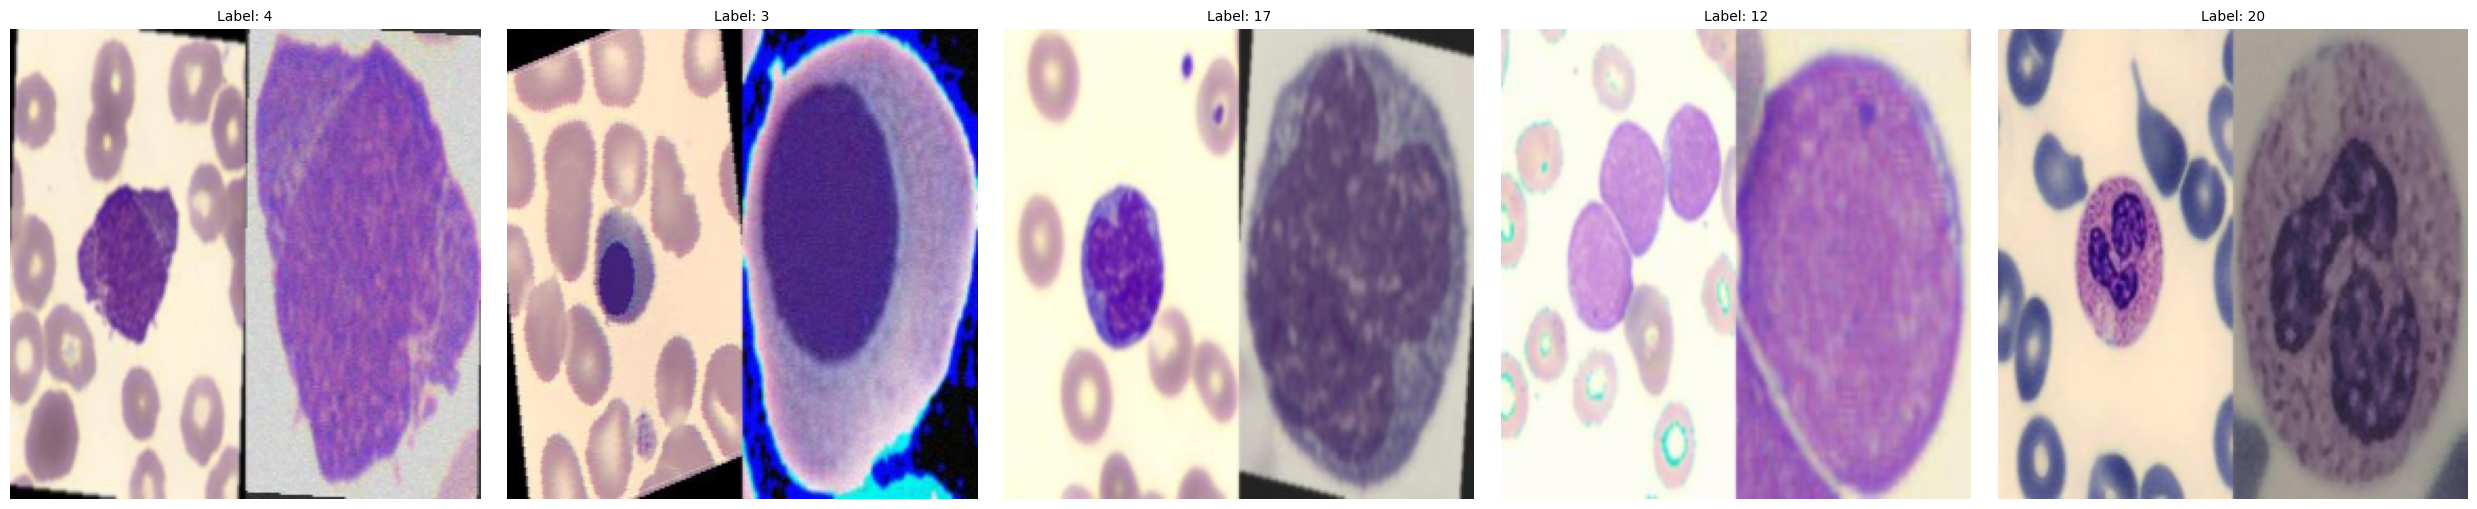

Exemplos do val_dataset:


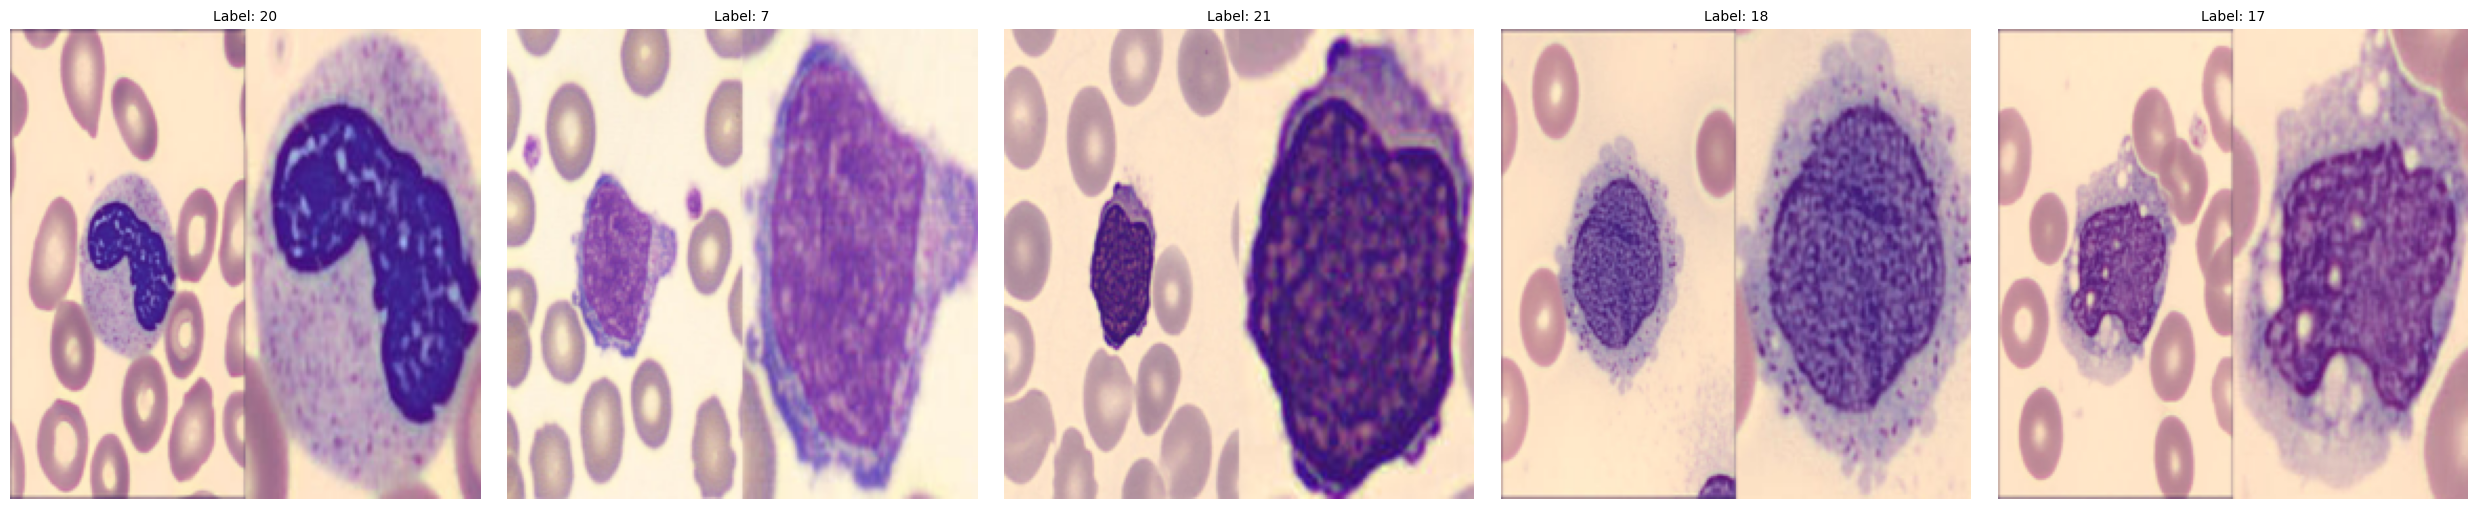

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
<ipython-input-104-d8efd532eabf>:504: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = tor

Camada patch_embed congelada.
Bloco 0 congelado.
Bloco 1 congelado.
Bloco 2 congelado.
Bloco 3 congelado.
Bloco 4 congelado.
Bloco 5 congelado.
Bloco 6 congelado.
Bloco 7 congelado.
Bloco 8 congelado.
Bloco 9 congelado.
Bloco 10 congelado.
Bloco 11 congelado.
Shape final dos logits: torch.Size([1, 23]) (esperado [1, 23])
DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True

Train:  78%|███████▊  | 853/1100 [04:35<01:19,  3.10it/s, loss=1.0148]

In [ ]:
cross_validate_dinobloom(
    df,
    folds=FOLDS,
    random_seed=42,
    classes=CLASSES,  # Lista de rótulos
    path_images_train=PATH_IMAGES_AUG,
    path_images_valid=PATH_IMAGES,
    output_dir="SWIN-crossval",
    epochs=EPOCHS,
    batch_size=BATCH,
    do_pca=False,
    n_pca_components=320,
    lr_schedule = [1e-3, 1e-3, 1e-3, 1e-4, 1e-4,1e-4,5e-5, 5e-5, 5e-6, 5e-6]
)

# submissao

In [ ]:
submission, test_df = inference_with_crossval_dinobloom(
    test_,
    path_models="SWIN-crossval",
    folds=FOLDS,
    num_classes=23,
    classes=CLASSES,  # lista de rótulos (ex: CLASSES)
    label_encoder=label_encoder,
    path_images=PATH_IMAGES,  # Caminho para imagens se seu TestDataset usa isso
    batch_size=BATCH,
    output_submission="submission.csv",
    output_inference_df="inference_with_pca.csv",
    pca_model_path="pca_model.pkl",
    device="cuda"
)

display(submission)
display(test_df)

In [ ]:
# Definir caminhos de origem e destino
source_path = '/content/SWIN-crossval'
dest_path = '/content/drive/MyDrive/SWIN-crossval'

# Criar diretório de destino se não existir
os.makedirs(dest_path, exist_ok=True)

# Copiar todo o conteúdo
shutil.copytree(source_path, dest_path, dirs_exist_ok=True)

print(f"Conteúdo copiado com sucesso para: {dest_path}")